# Hastings Direct Takehome

Background:
Insurance companies make pricing decisions based on historical claims experience. The more recent the claims experience, the more predictive it may be of future losses. In the case of many large claims however, the exact cost is not known at the time of the accident. In fact, some cases take years to develop and settle. Companies sometimes learn that a claim is large several years after the accident took place.
Your Underwriting Director believes it is possible to predict the ultimate value of individual claims well in advance by using FNOL (First Notification Of Loss) characteristics. This is the information recorded when the claim is first notified. If so, it would allow the company to know about future costs earlier and this information could be used to make better pricing decisions.
You are given a historical dataset of a particular type of claim - head-on collisions - and are also told their individual current estimated values (labelled Incurred). (Given these claims are now a few years old, you can assume the incurred values are equal to the cost at which the claims will finally settle). 

Task breakdown:
1) Using this data, build a model to predict the ultimate individual claim amounts
"2) Prepare a 15 minute presentation summarising your model. Your presentation should either be in notebook format or a more traditional slide deck.  If you opt for the slide deck approach, please make sure that you provide supporting code. 
Your presentation should cover the following aspects:
- Issues identified with the data and how these were addressed
- Data cleansing
- Model specification and justification for selecting this model specification
- Assessment of your model's accuracy and model diagnostics
- Suggestions of how your model could be improved
- Practical challenges for implementing your model"

Note: columns beginning with TP_* show the number of third parties involved in an accident (under a given category)

# Modelling

See notebook 01_ for data processing etc

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
from pprint import pprint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pickle
from catboost import CatBoostRegressor, Pool
import optuna
pd.set_option('display.max_rows', 500)

In [2]:
full_train = pd.read_parquet('data/full_train.parquet')
full_test = pd.read_parquet('data/full_test.parquet')
recent_train = pd.read_parquet('data/recent_train.parquet')
recent_test = pd.read_parquet('data/recent_test.parquet')

In [3]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

column_meta_org = load_pickle('data/column_meta_org.pkl')

A reminder of date based feature quality and definition of full and recent train splits:

### Test Train split

Features with bad coverage across dates:

* count of observations: low until 2012 when it starts growing
* weather: spike in n/k after 2015
* main_driver: only use after 2012
* ph_considered_tp_at_fault: 2012 +
* tp_type: 2012+

Date Splits:

1. full_train - upto 2014
2. full_test - 2014 onwards
3. recent_train - 2012-2014q3
4. recent_test - 2014q3 onwards

# Random Forest

Trying this algorithm first as it is efficient and strong at predictive accuracy. If I want a more explainable model I can also refer to feature importance here to help narrow down predictors. 

In [4]:
from catboost import CatBoostRegressor, Pool
import optuna
import pandas as pd

def train_catboost_rf(
    train_df
  , target
#   , id_col='claim_number'
#   , exclude_cols=[
#         'incurred',
#         'capped_incurred',
#         'incurred_log',
#         'capped_incurred_log'
#     ]
#   , include_cols=[]
  , loss_function = 'RMSE'
  , tune=False
):
    # if exclude_cols is None:
    #     exclude_cols = []
    train_df = train_df.copy()

    # --- Determine feature set ---
    # exclude_cols = [c for c in exclude_cols if c != target]
    # if include_cols:
    #     features = include_cols
    # else:
    features = train_df.drop(columns=[target]).columns.tolist()

    X = train_df[features]
    y = train_df[target]

    # --- Detect categorical columns ---
    cat_features = X.select_dtypes(include='category').columns.tolist()
    if not cat_features:
        cat_features = X.select_dtypes(include='object').columns.tolist()

    train_pool = Pool(data=X, label=y, cat_features=cat_features)

    # --- Hyperparameter tuning via Optuna ---
    if tune:
        def objective(trial):
            params = {
                'loss_function': loss_function
              , 'eval_metric': loss_function
              , 'random_strength': trial.suggest_float('random_strength', 0, 10)
              , 'depth': trial.suggest_int('depth', 4, 16)
              , 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
              , 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True)
              , 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1)
              , 'border_count': trial.suggest_int('border_count', 32, 255)
              , 'iterations': 2000
              , 'random_seed': 42
              , 'verbose': 0
              , 'task_type': 'CPU'
            }
            model = CatBoostRegressor(**params)
            model.fit(train_pool)
            preds = model.predict(train_pool)
            return ((preds - y) ** 2).mean() ** 0.5  # RMSE

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=30)
        best_params = study.best_params
        best_params.update({
            'loss_function': loss_function
          , 'iterations': 2000
          , 'verbose': 0
          , 'random_seed': 42
          , 'task_type': 'CPU'
        })
    else:
        best_params = {
            'loss_function': loss_function
          , 'iterations': 2000
          , 'depth': 12
          , 'learning_rate': 0.05
          , 'random_strength': 1
          , 'bagging_temperature': 0.5
          , 'l2_leaf_reg': 10
          , 'verbose': 0
          , 'random_seed': 42
          , 'task_type': 'CPU'
        }

    # --- Fit final model ---
    model = CatBoostRegressor(**best_params)
    model.fit(train_pool)

    return model, features

In [5]:
target = 'capped_incurred'
id_col = 'claim_number'

In [6]:
column_meta_org.summarise_concepts()

,concept,encoding,n_cols,avg_r2
0,tp_injury,count,5,0.370611
1,tp_injury,loo,6,0.370611
2,tp_region,dummy,12,0.272467
3,tp_region,loo,14,0.272467
4,tp_region,count,12,0.272467
5,tp_type,loo,10,0.266144
6,tp_type,count,9,0.266144
7,tp_total,count,1,0.097487
8,vehicle_mobile,loo,1,0.045440
9,vehicle_mobile,dummy,3,0.045440


In [7]:
cols_to_use = column_meta_org.select_cols(
    concepts=['tp_injury', 'tp_region'],
    encodings=['count'],
    include_cols=[],
    exclude_cols=[]
    )

cols_to_use.extend(column_meta_org.select_cols(
    concepts=['vehicle_mobile', 'location_of_incident'],
    encodings=['dummy'],
    include_cols=[],
    exclude_cols=[]
    ))

cols_to_use.append(target)
cols_to_use

['tp_injury_whiplash',
 'tp_injury_traumatic',
 'tp_injury_fatality',
 'tp_injury_unclear',
 'tp_injury_nk',
 'tp_region_eastang',
 'tp_region_eastmid',
 'tp_region_london',
 'tp_region_north',
 'tp_region_northw',
 'tp_region_outerldn',
 'tp_region_scotland',
 'tp_region_southe',
 'tp_region_southw',
 'tp_region_wales',
 'tp_region_westmid',
 'tp_region_yorkshire',
 'location_of_incident_dum_Car Park',
 'location_of_incident_dum_Home Address',
 'location_of_incident_dum_Main Road',
 'location_of_incident_dum_Minor Road',
 'location_of_incident_dum_Motorway',
 'location_of_incident_dum_Not Applicable',
 'location_of_incident_dum_Other',
 'location_of_incident_dum_n/k',
 'vehicle_mobile_dum_N',
 'vehicle_mobile_dum_Y',
 'vehicle_mobile_dum_n/k',
 'capped_incurred']

In [8]:
train_df = column_meta_org.filter_df(full_train, cols_to_use)
test_df = column_meta_org.filter_df(full_test, cols_to_use)

In [9]:
model, features = train_catboost_rf(
    train_df=train_df
  , target=target
  # , id_col='claim_number'
  , tune=False
)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval(preds, test_df, target='capped_incurred', date_col='date_of_loss', group_cols=None):
    """
    Evaluate predictive performance and plot residual diagnostics and grouped metrics.

    Assumes test_df and preds are pre-aligned and filtered. Plots residuals vs actuals and predicted vs actuals.
    Optionally plots RMSE, MAE, and R² grouped by time or categorical columns.
    """
    y_true = test_df[target].values
    y_pred = preds.values if isinstance(preds, pd.Series) else np.asarray(preds)

    df = test_df.copy()
    df['pred'] = y_pred
    df['residual'] = df[target] - df['pred']

    mse = mean_squared_error(y_true, y_pred)

    summary = {
        'rmse': mse**0.5
      , 'mae': mean_absolute_error(y_true, y_pred)
      , 'r2': r2_score(y_true, y_pred)
    }

    print('Overall metrics:', summary)

    # --- Plot residuals vs actual ---
    plt.figure(figsize=(5, 3))
    plt.scatter(df[target], df['residual'], alpha=0.3, s=10)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Residual')
    plt.tight_layout()
    plt.show()

    # --- Plot predicted vs actual ---
    plt.figure(figsize=(5, 3))
    plt.scatter(df[target], df['pred'], alpha=0.3, s=10)
    min_val = min(df[target].min(), df['pred'].min())
    max_val = max(df[target].max(), df['pred'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.title('Predicted vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()
    plt.show()

    # --- Time-based faceted plots ---
    if date_col and date_col in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df['__date'] = df[date_col].dt.to_period('M').dt.to_timestamp()

        metrics = [
            ('rmse', lambda g: mean_squared_error(g[target], g['pred'])**0.5),
            ('mae', lambda g: mean_absolute_error(g[target], g['pred'])),
            ('r2', lambda g: r2_score(g[target], g['pred']))
        ]

        grouped = df.groupby('__date', group_keys=False)[[target, 'pred']].apply(
            lambda g: pd.Series({name: fn(g) for name, fn in metrics})
        ).reset_index()

        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6), sharex=True)
        for i, (name, _) in enumerate(metrics):
            ax = axes[i]
            ax.plot(grouped['__date'], grouped[name], marker='o', markersize=3)
            ax.set_title(f'{name.upper()} by {date_col}', fontsize=9)
            ax.set_ylabel(name.upper(), fontsize=8)
            ax.tick_params(axis='both', labelsize=8)
            ax.grid(True)

        axes[-1].set_xlabel(date_col, fontsize=8)
        fig.tight_layout()
        plt.show()

    # --- Helper to plot group-based metrics ---
    def plot_grouped_metric(df, groupby_col, metric_fn, metric_name):
        def compute_metric(g):
            return metric_fn(g[target], g['pred']) if metric_name != 'rmse' else mean_squared_error(g[target], g['pred'])**0.5

        grouped = (
            df.groupby(groupby_col, group_keys=False)[[target, 'pred']]
            .apply(compute_metric)
            .reset_index(name=metric_name)
        )

        if grouped.empty:
            print(f"[warn] No groups found for {groupby_col}")
            return

        plt.figure(figsize=(6, 3))
        plt.plot(grouped[groupby_col], grouped[metric_name], marker='o', markersize=3)
        plt.title(f'{metric_name.upper()} by {groupby_col}', fontsize=9)
        plt.xlabel(groupby_col, fontsize=8)
        plt.ylabel(metric_name.upper(), fontsize=8)
        plt.xticks(rotation=45, fontsize=8)
        plt.yticks(fontsize=8)
        plt.tight_layout()
        plt.show()

    # --- Group-based plots ---
    if group_cols:
        for col in group_cols:
            if col in df.columns:
                for fn, name in [
                    (mean_squared_error, 'rmse'),
                    (mean_absolute_error, 'mae'),
                    (r2_score, 'r2')
                ]:
                    plot_grouped_metric(df, col, fn if name != 'rmse' else lambda a, b: mean_squared_error(a, b)**0.5, name)

    return summary

In [11]:
preds = model.predict(test_df)

Overall metrics: {'rmse': 9375.43740209237, 'mae': 5736.843776220024, 'r2': 0.2651958356665757}


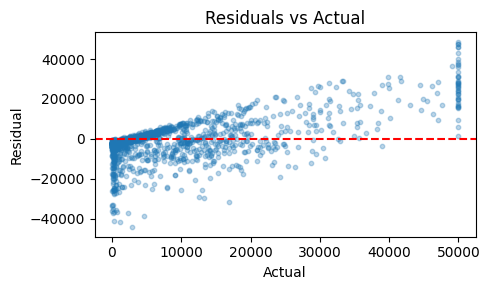

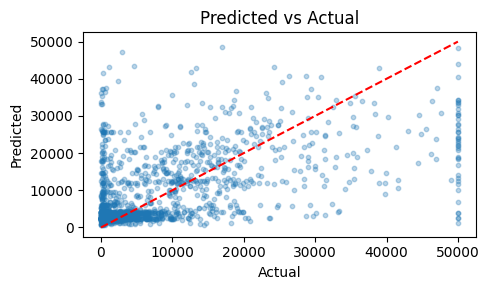

{'rmse': 9375.43740209237, 'mae': 5736.843776220024, 'r2': 0.2651958356665757}

In [12]:
eval(preds, test_df, target=target, group_cols=['tp_total'])

In [13]:
importances = model.get_feature_importance(type='FeatureImportance')
feature_names = model.feature_names_

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [14]:
feat_imp_df

,feature,importance
0,tp_injury_whiplash,35.598344
1,tp_injury_traumatic,19.828898
2,tp_injury_unclear,10.193934
3,tp_injury_nk,5.922008
4,vehicle_mobile_dum_N,3.882892
5,location_of_incident_dum_Main Road,3.252119
6,location_of_incident_dum_Minor Road,2.902310
7,vehicle_mobile_dum_Y,2.135471
8,tp_region_southe,1.590591
9,vehicle_mobile_dum_n/k,1.559459


Whether I use logged target or not the predictions are still clustered in an average range and not reflecting the target. Try using a smaller feature set I know has a good chance of predictive power

In [15]:
target = 'capped_incurred'

In [16]:
column_meta_org.summarise_concepts()

,concept,encoding,n_cols,avg_r2
0,tp_injury,count,5,0.370611
1,tp_injury,loo,6,0.370611
2,tp_region,dummy,12,0.272467
3,tp_region,loo,14,0.272467
4,tp_region,count,12,0.272467
5,tp_type,loo,10,0.266144
6,tp_type,count,9,0.266144
7,tp_total,count,1,0.097487
8,vehicle_mobile,loo,1,0.045440
9,vehicle_mobile,dummy,3,0.045440


In [17]:
cols_to_use = column_meta_org.select_cols(
    concepts=['tp_injury', 'tp_region'],
    encodings=['count'],
    include_cols=[],
    exclude_cols=[]
    )

cols_to_use.extend(column_meta_org.select_cols(
    concepts=['vehicle_mobile', 'location_of_incident', 'injury_details_present', 'hour_bin', 'weather_conditions', 'dow_bin'],
    encodings=['dummy'],
    include_cols=[],
    exclude_cols=[]
    ))

cols_to_use.append(target)
cols_to_use

['tp_injury_whiplash',
 'tp_injury_traumatic',
 'tp_injury_fatality',
 'tp_injury_unclear',
 'tp_injury_nk',
 'tp_region_eastang',
 'tp_region_eastmid',
 'tp_region_london',
 'tp_region_north',
 'tp_region_northw',
 'tp_region_outerldn',
 'tp_region_scotland',
 'tp_region_southe',
 'tp_region_southw',
 'tp_region_wales',
 'tp_region_westmid',
 'tp_region_yorkshire',
 'location_of_incident_dum_Car Park',
 'location_of_incident_dum_Home Address',
 'location_of_incident_dum_Main Road',
 'location_of_incident_dum_Minor Road',
 'location_of_incident_dum_Motorway',
 'location_of_incident_dum_Not Applicable',
 'location_of_incident_dum_Other',
 'location_of_incident_dum_n/k',
 'weather_conditions_dum_N/K',
 'weather_conditions_dum_NORMAL',
 'weather_conditions_dum_SNOW,ICE,FOG',
 'weather_conditions_dum_WET',
 'vehicle_mobile_dum_N',
 'vehicle_mobile_dum_Y',
 'vehicle_mobile_dum_n/k',
 'injury_details_present',
 'hour_bin_dum_afternoon',
 'hour_bin_dum_early_am_spike',
 'hour_bin_dum_evening'

In [18]:
train_df = column_meta_org.filter_df(full_train, cols_to_use)
test_df = column_meta_org.filter_df(full_test, cols_to_use)

In [19]:
model2, features = train_catboost_rf(
    train_df=train_df
  , target=target
  , tune=False
)

In [20]:
preds2 = model2.predict(test_df)

Overall metrics: {'rmse': 9339.161271680437, 'mae': 5800.0256677408215, 'r2': 0.2708711511026106}


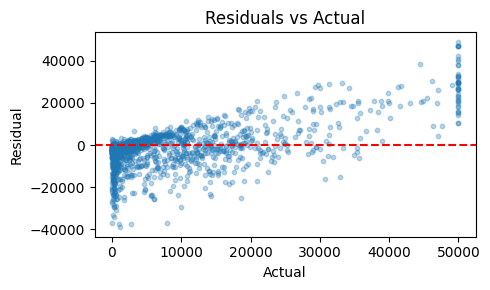

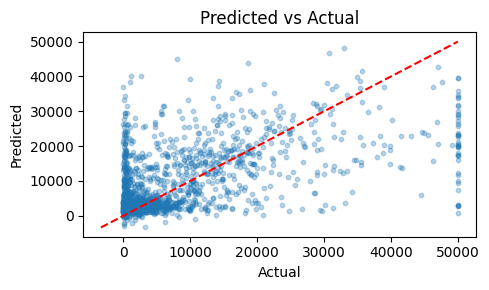

{'rmse': 9339.161271680437,
 'mae': 5800.0256677408215,
 'r2': 0.2708711511026106}

In [21]:
eval(preds2, test_df, target=target, group_cols=['tp_total'])

In [22]:
importances = model2.get_feature_importance(type='FeatureImportance')
feature_names = model2.feature_names_

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [23]:
feat_imp_df

,feature,importance
0,tp_injury_whiplash,24.554005
1,tp_injury_traumatic,13.836131
2,tp_injury_unclear,8.447666
3,injury_details_present,5.818143
4,tp_injury_nk,5.250577
5,vehicle_mobile_dum_N,3.577203
6,weather_conditions_dum_NORMAL,3.163045
7,location_of_incident_dum_Minor Road,3.021831
8,location_of_incident_dum_Main Road,2.910473
9,hour_bin_dum_afternoon,2.905443


Try using encoded features instead of dummies

In [24]:
column_meta_org.summarise_concepts()

,concept,encoding,n_cols,avg_r2
0,tp_injury,count,5,0.370611
1,tp_injury,loo,6,0.370611
2,tp_region,dummy,12,0.272467
3,tp_region,loo,14,0.272467
4,tp_region,count,12,0.272467
5,tp_type,loo,10,0.266144
6,tp_type,count,9,0.266144
7,tp_total,count,1,0.097487
8,vehicle_mobile,loo,1,0.045440
9,vehicle_mobile,dummy,3,0.045440


In [25]:
cols_to_use = column_meta_org.select_cols(
    concepts=['tp_injury', 'tp_region'],
    encodings=['loo'],
    include_cols=[],
    exclude_cols=[]
    )

cols_to_use.extend(column_meta_org.select_cols(
    concepts=['vehicle_mobile', 'location_of_incident', 'injury_details_present', 'hour_bin', 'weather_conditions', 'dow_bin'],
    encodings=['loo'],
    include_cols=[],
    exclude_cols=[]
    ))

cols_to_use.append(target)
cols_to_use

['tp_injury_whiplash_enc',
 'tp_injury_traumatic_enc',
 'tp_injury_fatality_enc',
 'tp_injury_unclear_enc',
 'tp_injury_nk_enc',
 'tp_injury_enc',
 'tp_region_loo',
 'tp_region_eastang_enc',
 'tp_region_eastmid_enc',
 'tp_region_london_enc',
 'tp_region_north_enc',
 'tp_region_northw_enc',
 'tp_region_outerldn_enc',
 'tp_region_scotland_enc',
 'tp_region_southe_enc',
 'tp_region_southw_enc',
 'tp_region_wales_enc',
 'tp_region_westmid_enc',
 'tp_region_yorkshire_enc',
 'tp_region_enc',
 'location_of_incident_loo',
 'weather_conditions_loo',
 'vehicle_mobile_loo',
 'hour_bin_loo',
 'dow_bin_loo',
 'capped_incurred']

In [26]:
train_df = column_meta_org.filter_df(full_train, cols_to_use)
test_df = column_meta_org.filter_df(full_test, cols_to_use)

In [27]:
model3, features = train_catboost_rf(
    train_df=train_df
  , target=target
  , tune=False
)

In [28]:
preds3 = model3.predict(test_df)

Overall metrics: {'rmse': 9426.228094062608, 'mae': 5824.707074690916, 'r2': 0.25721278320216634}


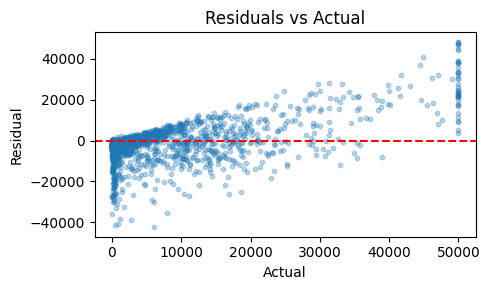

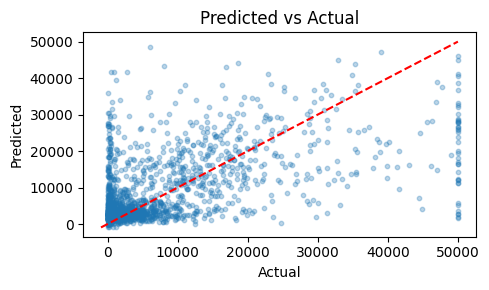

{'rmse': 9426.228094062608,
 'mae': 5824.707074690916,
 'r2': 0.25721278320216634}

In [29]:
eval(preds3, test_df, target=target, group_cols=['tp_total'])

In [30]:
importances = model3.get_feature_importance(type='FeatureImportance')
feature_names = model3.feature_names_

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [31]:
feat_imp_df

,feature,importance
0,tp_injury_enc,19.387055
1,tp_region_enc,12.726010
2,hour_bin_loo,8.762390
3,location_of_incident_loo,7.880713
4,vehicle_mobile_loo,7.717462
5,weather_conditions_loo,7.176205
6,dow_bin_loo,6.727077
7,tp_injury_whiplash_enc,5.362594
8,tp_region_loo,5.146458
9,tp_injury_unclear_enc,4.754389


Try using recent data only

In [32]:
target = 'capped_incurred'

In [33]:
column_meta_org.summarise_concepts()

,concept,encoding,n_cols,avg_r2
0,tp_injury,count,5,0.370611
1,tp_injury,loo,6,0.370611
2,tp_region,dummy,12,0.272467
3,tp_region,loo,14,0.272467
4,tp_region,count,12,0.272467
5,tp_type,loo,10,0.266144
6,tp_type,count,9,0.266144
7,tp_total,count,1,0.097487
8,vehicle_mobile,loo,1,0.045440
9,vehicle_mobile,dummy,3,0.045440


In [34]:
cols_to_use = column_meta_org.select_cols(
    concepts=['tp_injury', 'tp_region', 'tp_type'],
    encodings=['count'],
    include_cols=[],
    exclude_cols=[]
    )

cols_to_use.extend(column_meta_org.select_cols(
    concepts=['vehicle_mobile', 'injury_details_present'],
    encodings=['dummy'],
    include_cols=[],
    exclude_cols=[]
    ))

cols_to_use.extend(column_meta_org.select_cols(
    concepts=['location_of_incident', 'hour_bin', 'weather_conditions', 'dow_bin'],
    encodings=['loo'],
    include_cols=[],
    exclude_cols=[]
    ))

cols_to_use.append(target)

In [35]:
train_df = column_meta_org.filter_df(recent_train, cols_to_use)
test_df = column_meta_org.filter_df(recent_test, cols_to_use)

In [36]:
model4, features = train_catboost_rf(
    train_df=train_df
  , target=target
  , tune=False
)

In [37]:
preds4 = model4.predict(test_df)

Overall metrics: {'rmse': 9036.195840264101, 'mae': 5506.4571443772165, 'r2': 0.3165441644702963}


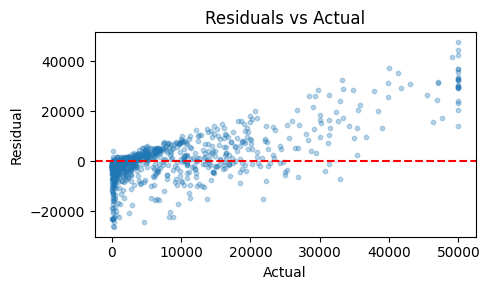

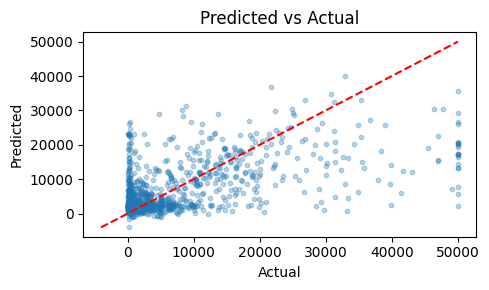

{'rmse': 9036.195840264101,
 'mae': 5506.4571443772165,
 'r2': 0.3165441644702963}

In [38]:
eval(preds4, test_df, target=target, group_cols=['tp_total'])

In [39]:
importances = model4.get_feature_importance(type='FeatureImportance')
feature_names = model4.feature_names_

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_imp_df

,feature,importance
0,tp_injury_whiplash,18.739814
1,tp_injury_traumatic,11.615042
2,tp_type_pass_front,7.124867
3,hour_bin_loo,7.062563
4,tp_injury_nk,6.248069
5,tp_injury_unclear,6.213923
6,dow_bin_loo,5.657607
7,location_of_incident_loo,5.276551
8,injury_details_present,4.439637
9,weather_conditions_loo,3.839056


Try different loss function to better capture range of output

In [40]:
model5, features = train_catboost_rf(
    train_df=train_df
  , target=target
  , tune=False
  , loss_function='MAE'
)

In [41]:
preds5 = model5.predict(test_df)

Overall metrics: {'rmse': 8765.407739759763, 'mae': 5155.972820490154, 'r2': 0.35689271035766357}


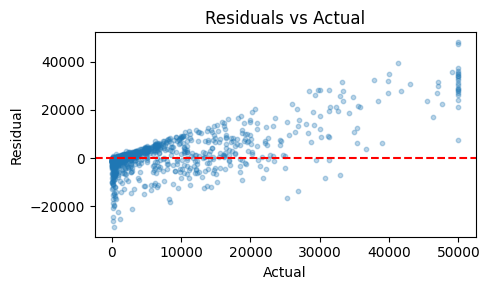

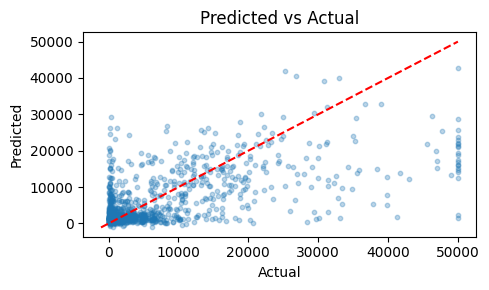

{'rmse': 8765.407739759763,
 'mae': 5155.972820490154,
 'r2': 0.35689271035766357}

In [42]:
eval(preds5, test_df, target=target, group_cols=['tp_total'])

In [43]:
importances = model4.get_feature_importance(type='FeatureImportance')
feature_names = model4.feature_names_

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_imp_df

,feature,importance
0,tp_injury_whiplash,18.739814
1,tp_injury_traumatic,11.615042
2,tp_type_pass_front,7.124867
3,hour_bin_loo,7.062563
4,tp_injury_nk,6.248069
5,tp_injury_unclear,6.213923
6,dow_bin_loo,5.657607
7,location_of_incident_loo,5.276551
8,injury_details_present,4.439637
9,weather_conditions_loo,3.839056


Try changing target

In [51]:
target = 'capped_incurred_log'

In [52]:
cols_to_use = column_meta_org.select_cols(
    concepts=['tp_injury', 'tp_region', 'tp_type'],
    encodings=['count'],
    include_cols=[],
    exclude_cols=[]
    )

cols_to_use.extend(column_meta_org.select_cols(
    concepts=['vehicle_mobile', 'injury_details_present'],
    encodings=['dummy'],
    include_cols=[],
    exclude_cols=[]
    ))

cols_to_use.extend(column_meta_org.select_cols(
    concepts=['location_of_incident', 'hour_bin', 'weather_conditions', 'dow_bin'],
    encodings=['loo'],
    include_cols=[],
    exclude_cols=[]
    ))

cols_to_use.append(target)

In [53]:
train_df = column_meta_org.filter_df(recent_train, cols_to_use)
test_df = column_meta_org.filter_df(recent_test, cols_to_use)

In [54]:
model6, features = train_catboost_rf(
    train_df=train_df
  , target=target
  , tune=False
  , loss_function='MAE'
)

In [55]:
preds6 = model6.predict(test_df)

Overall metrics: {'rmse': 1.768815032255173, 'mae': 1.3996805816527247, 'r2': 0.10884180744633631}


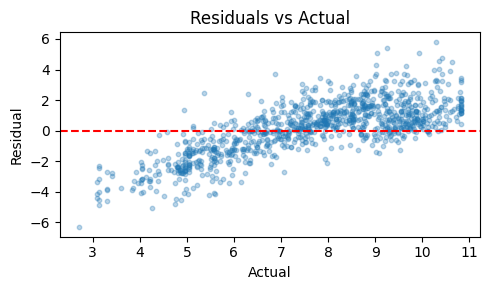

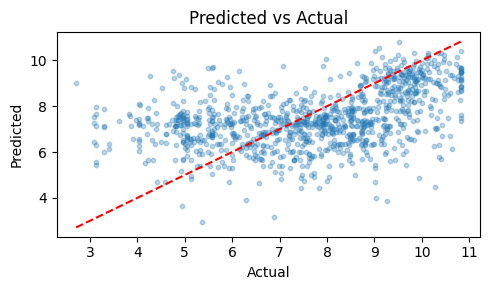

{'rmse': 1.768815032255173,
 'mae': 1.3996805816527247,
 'r2': 0.10884180744633631}

In [56]:
eval(preds6, test_df, target=target, group_cols=['tp_total'])

In [57]:
importances = model6.get_feature_importance(type='FeatureImportance')
feature_names = model6.feature_names_

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_imp_df

,feature,importance
0,tp_injury_whiplash,11.842659
1,hour_bin_loo,10.228165
2,location_of_incident_loo,9.211671
3,dow_bin_loo,8.587775
4,weather_conditions_loo,7.441936
5,tp_injury_nk,6.866920
6,injury_details_present,6.548521
7,tp_injury_unclear,5.513392
8,tp_injury_traumatic,5.345244
9,vehicle_mobile_dum_Y,4.087744
